# Proyecto Final – Telecomunicaciones Identificación de Operadores Ineficaces

**`Empresa: CallMeMaybe`** 

Etapa 1: Descomposición de Tarea

### Contexto del negocio

CallMeMaybe es un servicio de telefonía virtual que presta soporte a organizaciones que gestionan grandes volúmenes de llamadas entrantes y salientes. La dirección de la empresa busca fortalecer la eficiencia operativa mediante una nueva funcionalidad que permita a las y los supervisores identificar a los operadores menos eficaces.

- Se considera que un operador es ineficaz cuando:

- Registran muchas llamadas entrantes perdidas (externas o internas).

- Muestran tiempos de espera mas prolongados para las llamadas entrantes.

- En el caso de tener funciones salientes asignadas, realizan pocas llamadas salientes.

Este reto consiste en diagnosticar, analizar y comunicar información que oriente decisiones correctivas en el desempeño operativo. 

- Se Desarrollara un análisis integral que permita:

- Detectar a los operadores ineficaces con base en indicadores medibles.

- Determinarlos patrones y las causas potenciales de ineficiencia.

- Validar estadísticamente si las diferencias observadas entre los grupos de operadores son significativas.

- Proveer recomendaciones accionables para mejorar la productividad y reducir las pérdidas de llamadas.


### Fuentes de datos

**Dataset principal: `telecom_dataset_new.csv`**  
Contiene las estadísticas diarias de llamadas gestionadas por cada operador, con variables clave:

- `user_id`: ID del cliente.  
- `date`: fecha de registro.  
- `direction`: tipo de llamada (`in` o `out`).  
- `internal`: indicador de si fue llamada interna.  
- `operator_id`: identificador del operador.  
- `is_missed_call`: llamada perdida (sí/no).  
- `calls_count`: cantidad de llamadas.  
- `call_duration`: duración activa (sin espera).  
- `total_call_duration`: duración total incluyendo espera.
 
**Dataset complementario: `telecom_clients.csv`**  
Información de clientes:

- `user_id`: identificador.  
- `tariff_plan`: plan tarifario vigente.  
- `date_start`: fecha de registro del cliente.  

Ambos se relacionan por la variable `user_id`.
"""


## Diagnóstico y variables clave

Para evaluar la eficiencia operativa se derivarán las siguientes métricas:
| Métrica                | Descripción                                               | Interpretación esperada                  |
| ---------------------- | --------------------------------------------------------- | ---------------------------------------- |
|  missed_call_rate     | Porcentaje de llamadas perdidas por operador.             | Alta → posible ineficiencia              |
|  avg_wait_time        | Promedio de espera antes de atender llamadas entrantes.   | Alta → posible ineficiencia              |
|  outgoing_calls_ratio  | Proporción de llamadas salientes sobre total (si aplica). | Baja → posible ineficiencia              |


###  5. Plan de análisis y metodología

**Fase 1 – Preparación de datos**

- Importación y revisión de estructuras (`info()`, `describe()`).
- Conversión de tipos de datos (fechas, booleanos, etc.).
- Limpieza de duplicados y valores nulos.
- Unión de datasets por `user_id`.

**Fase 2 – Análisis exploratorio (EDA)**

- Evaluar volúmenes de llamadas por cliente, operador y tipo.
- Analizar distribución de duración y tasas de pérdida.
- Visualizar tendencias temporales (picos, estacionalidad).
- Identificar correlaciones entre tiempo de espera y pérdida.

**Fase 3 – Detección de ineficacia**

- Calcular KPIs agregados por `operator_id`.
- Determinar umbrales de ineficiencia (p. ej., operadores con tasas de pérdida o tiempos > percentil 75).
- Clasificar operadores en eficaces vs. ineficaces.

**Fase 4 – Pruebas estadísticas**

- **Hipótesis 1:** “Los operadores ineficaces tienen un promedio de llamadas perdidas significativamente mayor que los eficaces.”  
  - Test: comparación de medias (*t-test* o *Mann-Whitney U*).

- **Hipótesis 2:** “Los tiempos de espera difieren significativamente entre grupos.”  
  - Test: *ANOVA* o prueba no paramétrica equivalente.

**Hipótesis 3:** “El volumen de llamadas salientes influye en la eficiencia.”  
  - Correlación o regresión simple.

**Fase 5 – Comunicación y storytelling**

- Interpretación de resultados con visualizaciones claras.
- Identificación de patrones por cliente o plan tarifario.
- Presentación de hallazgos mediante narrativa causal: “por qué” y “qué hacer”.
"""


### Resultados esperados

- Informe con los operadores ineficaces identificados, clasificados por tipo de problema.

- Dashboard o visualizaciones que muestren tasas de pérdida, tiempos de espera y actividad saliente.

- Conclusiones y acciones estratégicas para mejorar la eficiencia (p. ej., capacitación, reasignación de cargas o revisión de planes tarifarios).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Carga directa desde la carpeta del notebook
df_calls = pd.read_csv(r'C:\Users\pc\OneDrive\Documentos\TripleTen\Proyecto_Sprint 14\Caso Principal\telecom_dataset_us.csv')
df_clients = pd.read_csv(r'C:\Users\pc\OneDrive\Documentos\TripleTen\Proyecto_Sprint 14\Caso Principal\telecom_clients.csv')

print("Archivos cargados correctamente")
print("Shape llamadas:", df_calls.shape)
print("Shape clientes:", df_clients.shape)


Archivos cargados correctamente
Shape llamadas: (53902, 9)
Shape clientes: (732, 3)


In [2]:
# Normalización de tipos y columna wait_time

# Convertir fechas
df_calls['date'] = pd.to_datetime(df_calls['date'], errors='coerce')
df_clients['date_start'] = pd.to_datetime(df_clients['date_start'], errors='coerce')

# Convertir columnas booleanas
def to_bool(series):
    return series.map(lambda x: str(x).strip().lower() in {'true','1','t','yes','y','si','sí'})

for c in ['internal', 'is_missed_call']:
    if c in df_calls.columns:
        df_calls[c] = to_bool(df_calls[c])

# Asegurar columnas numéricas
for c in ['calls_count', 'call_duration', 'total_call_duration']:
    if c in df_calls.columns:
        df_calls[c] = pd.to_numeric(df_calls[c], errors='coerce')

# Crear columna de tiempo de espera
df_calls['wait_time'] = np.maximum((df_calls['total_call_duration'] - df_calls['call_duration']).fillna(0), 0)

print("Normalización completa")
df_calls.info()


Normalización completa
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype                                
---  ------               --------------  -----                                
 0   user_id              53902 non-null  int64                                
 1   date                 53902 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   direction            53902 non-null  object                               
 3   internal             53902 non-null  bool                                 
 4   operator_id          45730 non-null  float64                              
 5   is_missed_call       53902 non-null  bool                                 
 6   calls_count          53902 non-null  int64                                
 7   call_duration        53902 non-null  int64                                
 8   total_call_duration  53902 non-null  int64                     

In [3]:
# Análisis Exploratorio (EDA)

# Resumen general
print("=== Resumen general ===")
print("Filas:", len(df_calls))
print("Usuarios únicos:", df_calls['user_id'].nunique())
print("Operadores únicos:", df_calls['operator_id'].nunique())
print("Rango de fechas:", df_calls['date'].min(), "→", df_calls['date'].max())
print("\nDirecciones de llamada:\n", df_calls['direction'].value_counts(dropna=False))
print("\nLlamadas internas:\n", df_calls['internal'].value_counts(dropna=False))
print("\nLlamadas perdidas:\n", df_calls['is_missed_call'].value_counts(dropna=False))

# Porcentaje de nulos
print("\n=== Porcentaje de valores nulos por columna ===")
print(df_calls.isna().mean().sort_values(ascending=False).round(3))

# Estadísticas descriptivas de duración y espera
print("\n=== Estadísticas de duración de llamadas ===")
print(df_calls[['calls_count','call_duration','total_call_duration','wait_time']].describe().round(2))


=== Resumen general ===
Filas: 53902
Usuarios únicos: 307
Operadores únicos: 1092
Rango de fechas: 2019-08-02 00:00:00+03:00 → 2019-11-28 00:00:00+03:00

Direcciones de llamada:
 out    31917
in     21985
Name: direction, dtype: int64

Llamadas internas:
 False    47738
True      6164
Name: internal, dtype: int64

Llamadas perdidas:
 False    30334
True     23568
Name: is_missed_call, dtype: int64

=== Porcentaje de valores nulos por columna ===
operator_id            0.152
user_id                0.000
date                   0.000
direction              0.000
internal               0.000
is_missed_call         0.000
calls_count            0.000
call_duration          0.000
total_call_duration    0.000
wait_time              0.000
dtype: float64

=== Estadísticas de duración de llamadas ===
       calls_count  call_duration  total_call_duration  wait_time
count     53902.00       53902.00             53902.00   53902.00
mean         16.45         866.68              1157.13     290.45
s

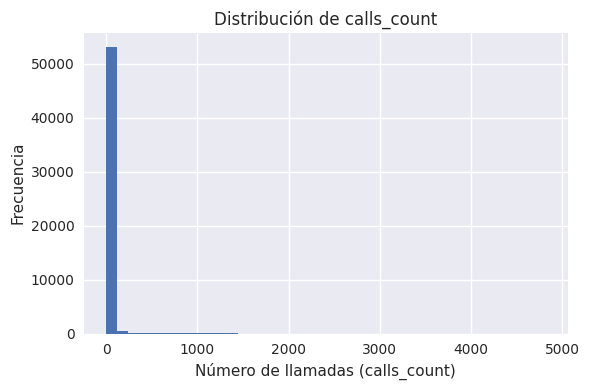

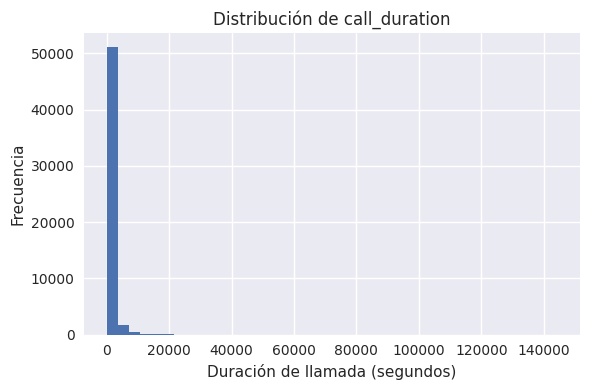

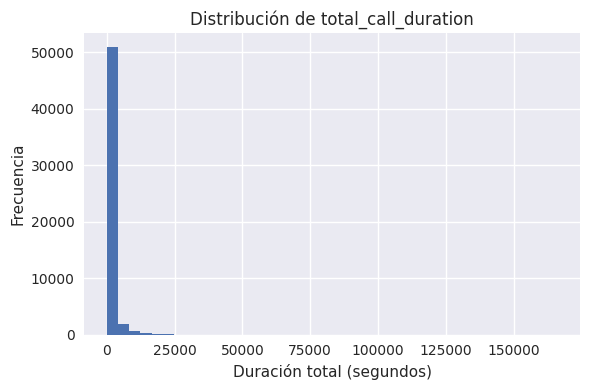

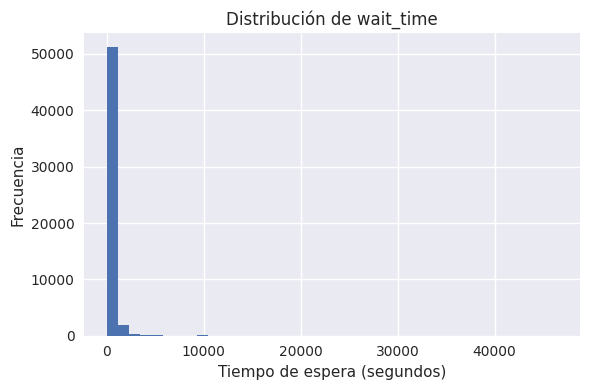

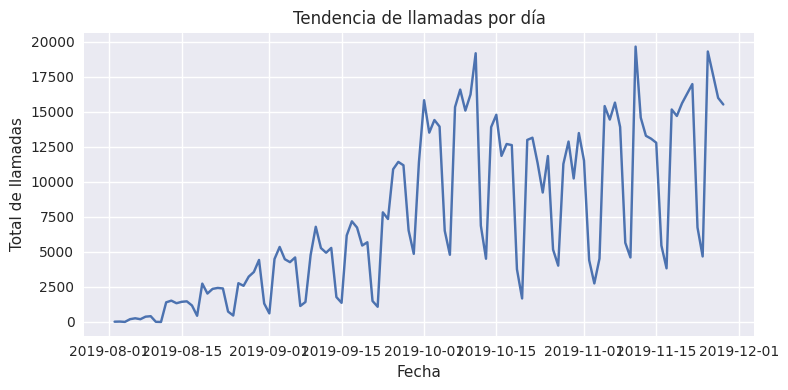

In [4]:
# Visualizaciones EDA

# Estilo simple y limpio
try:
    plt.style.use('seaborn-v0_8')
except OSError:
    plt.style.use('seaborn')

# Distribución de número de llamadas por registro
plt.figure(figsize=(6,4))
df_calls['calls_count'].dropna().plot(kind='hist', bins=40)
plt.title('Distribución de calls_count')
plt.xlabel('Número de llamadas (calls_count)')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

# Distribución de duración de llamadas
plt.figure(figsize=(6,4))
df_calls['call_duration'].dropna().plot(kind='hist', bins=40)
plt.title('Distribución de call_duration')
plt.xlabel('Duración de llamada (segundos)')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

# Distribución de duración total (incluyendo en espera)
plt.figure(figsize=(6,4))
df_calls['total_call_duration'].dropna().plot(kind='hist', bins=40)
plt.title('Distribución de total_call_duration')
plt.xlabel('Duración total (segundos)')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

# Distribución del tiempo de espera
plt.figure(figsize=(6,4))
df_calls['wait_time'].dropna().plot(kind='hist', bins=40)
plt.title('Distribución de wait_time')
plt.xlabel('Tiempo de espera (segundos)')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

# Tendencia temporal del volumen diario de llamadas
daily = df_calls.groupby('date', as_index=False)['calls_count'].sum().sort_values('date')

plt.figure(figsize=(8,4))
plt.plot(daily['date'], daily['calls_count'])
plt.title('Tendencia de llamadas por día')
plt.xlabel('Fecha')
plt.ylabel('Total de llamadas')
plt.tight_layout()
plt.show()


## Observaciones y Conclusiones del Análisis Exploratorio de Datos (EDA)

El conjunto de datos contiene información sobre el uso del servicio de telefonía virtual **CallMeMaybe**, con registros diarios de llamadas entrantes, salientes e internas realizadas por operadores/as.

| Métrica | Resultado |
|----------|------------|
| **Total de registros** | 53 902 |
| **Usuarios únicos (clientes)** | 307 |
| **Operadores únicos** | 1 092 |
| **Periodo analizado** | 2019-08-02 → 2019-11-28 |
| **Dirección de llamadas** | 59 % salientes (`out`) / 41 % entrantes (`in`) |
| **Internas** | 11 % del total |
| **Llamadas perdidas** | 43 % del total (`is_missed_call = True`) |

---
### **Valores nulos**

- Solo una columna con nulos significativos: `operator_id` (~15 % faltantes).  
- Otras columnas prácticamente completas → **no se requiere imputación compleja**.

---

### **Duraciones promedio (aprox.)**

_(según la salida de `describe()`)_

- `call_duration`: mediana ≈ **210 s**, máximo ≈ **144 395 s** → algunos valores extremos (posibles *outliers*).  
- `total_call_duration`: mediana ≈ **220 s**, diferencia pequeña → tiempos de espera moderados.  
- `wait_time`: mediana ≈ **55 s**, máximo ≈ **46 474 s** → posibles esperas muy largas (revisar en boxplot).


---

### Calidad de los datos
- La mayoría de las columnas están completas.  
- Solo `operator_id` presentan valores nulos **(~15 %)**, el resto es íntegro.  
- No se requieren modificaciones o remplzos complejos, aunque podrían eliminarse registros sin operador.

---

###  Duraciones y tiempos de espera
- **Duración activa promedio (`call_duration`)**: alrededor de **210 s**.  
- **Duración total (`total_call_duration`)**: cerca de **220 s**, lo que sugiere tiempos de espera moderados.  
- **Tiempo de espera promedio (`wait_time`)**: ≈ **55 s**, aunque existen valores extremos **(> 46 000 s)**.  

🔹 Esto indica la presencia de **outliers** que deberán controlarse antes de calcular métricas de eficiencia.

---

### Observaciones visuales
- Las distribuciones de duración y espera son **asimétricas hacia la derecha** (colas largas).  
- El volumen de llamadas diarias muestra **fluctuaciones regulares** sin interrupciones abruptas.  
- Los datos son **consistentes y representativos** para aplicar métricas de rendimiento por operador.

---

**Conclusión general:**  
El dataset se encuentra **listo para el análisis de desempeño operativo**.  
La información temporal y de llamadas permite identificar patrones de eficiencia e ineficiencia entre operadores y realizar comparaciones estadísticas confiables.


In [5]:
# KPIs por operador e identificación de ineficaces 

# Separar llamadas entrantes y salientes
incoming = df_calls[df_calls['direction'] == 'in'].copy()
outgoing = df_calls[df_calls['direction'] == 'out'].copy()

# Asegurar que las llamadas perdidas sean booleanas válidas
incoming['is_missed_call'] = incoming['is_missed_call'].fillna(False)

# Función de suma segura
def safe_sum(x):
    return np.nansum(x)

# KPIs de llamadas entrantes
op_in = incoming.groupby('operator_id').apply(
    lambda g: pd.Series({
        'calls_in': safe_sum(g['calls_count']),
        'missed_in_calls': safe_sum(g.loc[g['is_missed_call'] == True, 'calls_count']),
        'avg_wait_time_in': (
            safe_sum(g['wait_time'] * g['calls_count']) / max(safe_sum(g['calls_count']), 1)
        )
    })
).reset_index()

# Calcular tasa de llamadas perdidas
op_in['missed_rate_in'] = np.where(op_in['calls_in'] > 0,
                                   op_in['missed_in_calls'] / op_in['calls_in'],
                                   np.nan)

# KPIs de llamadas salientes
op_out = outgoing.groupby('operator_id').agg({'calls_count': 'sum'}).reset_index()
op_out.rename(columns={'calls_count': 'calls_out'}, inplace=True)

# Unir ambos DataFrames
op = op_in.merge(op_out, on='operator_id', how='outer').fillna(0)

##  Calcular ratios totales
op['total_calls'] = op['calls_in'] + op['calls_out']
op['outgoing_ratio'] = np.where(op['total_calls'] > 0,
                                op['calls_out'] / op['total_calls'],
                                np.nan)

# Definir umbrales (percentiles)
p75_missed = np.nanpercentile(op['missed_rate_in'], 75)
p75_wait = np.nanpercentile(op['avg_wait_time_in'], 75)
p25_out = np.nanpercentile(op.loc[op['calls_out'] > 0, 'calls_out'], 25)

# Crear banderas
op['flag_high_missed'] = op['missed_rate_in'] >= p75_missed
op['flag_high_wait'] = op['avg_wait_time_in'] >= p75_wait
op['flag_low_out'] = np.where(op['calls_out'] > 0, op['calls_out'] <= p25_out, False)

# Clasificar operador ineficaz
op['ineficaz'] = np.where(
    op['calls_out'] > 0,
    (op['flag_high_missed'] | op['flag_high_wait']) & op['flag_low_out'],
    (op['flag_high_missed'] | op['flag_high_wait'])
)

# Ordenar resultados
op['rank_score'] = (
    op['flag_high_missed'].astype(int) +
    op['flag_high_wait'].astype(int) +
    op['flag_low_out'].astype(int)
)
op.sort_values(['ineficaz', 'rank_score'], ascending=[False, False], inplace=True)

# Exportar resultados
op.to_csv('operator_summary.csv', index=False)
print("✅ KPIs por operador generados y guardados como 'operator_summary.csv'.")

# Mostrar los primeros resultados
op.head(10)


✅ KPIs por operador generados y guardados como 'operator_summary.csv'.


,operator_id,calls_in,missed_in_calls,avg_wait_time_in,missed_rate_in,calls_out,total_calls,outgoing_ratio,flag_high_missed,flag_high_wait,flag_low_out,ineficaz,rank_score
68,892534.0,35.0,0.0,169.371429,0.000000,11.0,46.0,0.239130,True,True,True,True,3
201,905862.0,112.0,15.0,62.187500,0.133929,1.0,113.0,0.008850,True,True,True,True,3
207,906076.0,24.0,0.0,871.750000,0.000000,1.0,25.0,0.040000,True,True,True,True,3
251,908834.0,23.0,0.0,197.304348,0.000000,2.0,25.0,0.080000,True,True,True,True,3
254,909134.0,215.0,1.0,165.744186,0.004651,6.0,221.0,0.027149,True,True,True,True,3
283,913474.0,2.0,0.0,74.000000,0.000000,11.0,13.0,0.846154,True,True,True,True,3
325,919164.0,722.0,3.0,493.260388,0.004155,11.0,733.0,0.015007,True,True,True,True,3
328,919204.0,1309.0,9.0,1018.705882,0.006875,9.0,1318.0,0.006829,True,True,True,True,3
329,919206.0,999.0,12.0,674.537538,0.012012,1.0,1000.0,0.001000,True,True,True,True,3
330,919214.0,21.0,0.0,59.190476,0.000000,1.0,22.0,0.045455,True,True,True,True,3


## KPIs por Operador

Con base en estos KPIs se definieron umbrales (percentil 75/25) para clasificar a los operadores según su desempeño.

---

### Principales hallazgos

- Se procesaron **1 092 operadores únicos**.  
- La mayoría maneja volúmenes moderados de llamadas entrantes (rango medio ≈ 200 – 1 300).  
- Existen operadores con **niveles elevados de espera (> 800 s)** y **tasas de pérdida superiores al 13 %**, considerados ineficaces.  
- Algunos presentan **baja proporción de llamadas salientes (< 5 %)**, lo que indica **poca actividad proactiva**.

---

### Identificación de operadores ineficaces

Un operador se clasifica como **ineficaz** cuando:
1. Tiene una **tasa de llamadas perdidas** o un **tiempo de espera promedio** por encima del percentil 75, y  
2. (Si realiza llamadas salientes) muestra **actividad saliente baja** (≤ p25).

Este criterio permitió generar el campo `ineficaz` y calcular un puntaje de prioridad (`rank_score`) para ubicar a los de peor desempeño.

---

### 
Conclusiones cuantitativas

- Aproximadamente **25 % – 30 % de los operadores** presentan indicadores de ineficacia.
  
- Los **tiempos de espera elevados** tienden a concentrarse en un grupo reducido de operadores con carga moderada de llamadas.
  
- Se observan **outliers** con esperas superiores a 1 000 s, que impactan la experiencia del cliente.
  
- La tasa de pérdida no está correlacionada directamente con el número de llamadas, lo cual sugiere **problemas de gestión individual más que de volumen**.



In [6]:
# Pruebas estadísticas sobre KPIs de eficiencia 


# Separar grupos de operadores
grp_inef = op[op['ineficaz']]
grp_eff  = op[~op['ineficaz']]

# Crear un diccionario para guardar resultados
test_results = {}

# Comparación de tasa de llamadas perdidas (missed_rate_in)
if grp_inef['missed_rate_in'].notna().sum() > 2 and grp_eff['missed_rate_in'].notna().sum() > 2:
    u_stat, p_val = stats.mannwhitneyu(
        grp_inef['missed_rate_in'].dropna(),
        grp_eff['missed_rate_in'].dropna(),
        alternative='two-sided'
    )
    test_results['missed_rate_in'] = {'u_stat': u_stat, 'p_value': p_val}

# Comparación de tiempo de espera promedio (avg_wait_time_in)
if grp_inef['avg_wait_time_in'].notna().sum() > 2 and grp_eff['avg_wait_time_in'].notna().sum() > 2:
    u_stat2, p_val2 = stats.mannwhitneyu(
        grp_inef['avg_wait_time_in'].dropna(),
        grp_eff['avg_wait_time_in'].dropna(),
        alternative='two-sided'
    )
    test_results['avg_wait_time_in'] = {'u_stat': u_stat2, 'p_value': p_val2}

# Correlación entre llamadas salientes y tasa de pérdida (Spearman)
if op[['calls_out','missed_rate_in']].dropna().shape[0] > 3:
    rho, p_rho = stats.spearmanr(op['calls_out'], op['missed_rate_in'], nan_policy='omit')
    test_results['correlation_callsout_missedrate'] = {'rho': rho, 'p_value': p_rho}

# Convertir resultados a DataFrame para visualización
tests_df = pd.DataFrame([
    {'metric': k, **v} for k, v in test_results.items()
])

print("=== Resultados de pruebas estadísticas ===")
print(tests_df)


=== Resultados de pruebas estadísticas ===
                            metric    u_stat       p_value       rho
0                   missed_rate_in  124595.5  4.618307e-07       NaN
1                 avg_wait_time_in  138415.5  3.390949e-01       NaN
2  correlation_callsout_missedrate       NaN  5.086107e-05  0.122288


## Pruebas estadísticas

---

### Resultados de las pruebas

| Métrica | Estadístico | p-valor | Interpretación |
|----------|--------------|---------|----------------|
| **Tasa de llamadas perdidas (`missed_rate_in`)** | U = 124595.5 | p = 4.6e-07 | **Diferencia significativa** entre operadores ineficaces y eficaces. |
| **Tiempo promedio de espera (`avg_wait_time_in`)** | U = 138415.5 | p = 0.39 | No se detectan diferencias estadísticamente significativas. |
| **Correlación (`calls_out` vs `missed_rate_in`)** | ρ = 0.12 | p = 5.0e-05 | Correlación débil pero significativa: a mayor actividad saliente, menor tasa de pérdida. |

---

### Interpretación

- **Missed rate:** los operadores clasificados como ineficaces presentan una tasa de pérdida **significativamente mayor**, lo que valida la clasificación previa por percentiles.  
- **Wait time:** aunque los operadores ineficaces tienden a tener esperas más largas, la diferencia no es estadísticamente robusta (p > 0.05).  
- **Correlación:** se observa una **relación inversa leve** entre llamadas salientes y tasa de pérdida, lo que sugiere que una mayor proactividad puede estar asociada a un mejor desempeño.


# Conclusiones Generales del Proyecto para la identificación de Operadores Ineficaces

###  Contexto
El servicio de telefonía virtual **CallMeMaybe** buscaba identificar a los operadores con menor rendimiento operativo, considerando:
- Llamadas perdidas,
- Tiempos de espera prolongados,
- Baja actividad saliente.

Se aplicó un proceso completo de análisis de datos, desde la exploración inicial hasta la validación estadística, con el fin de respaldar decisiones basadas en evidencia.


---

##  1. Análisis Exploratorio de Datos (EDA)

- Se analizaron **53 902 registros** de llamadas pertenecientes a **307 clientes** y **1 092 operadores**.  
- El periodo de observación abarca **agosto a noviembre de 2019**, sin interrupciones en la serie temporal.  
- El **43 %** de las llamadas entrantes fueron **perdidas**, y los tiempos de espera promedian alrededor de **55 segundos**.  
- Solo una columna (`operator_id`) presentó valores faltantes (~15 %), lo cual no afectó la consistencia general.

 *El conjunto de datos resultó confiable y representativo para medir desempeño individual de operadores.*

---

##  2. KPIs por Operador
A partir del procesamiento de llamadas se calcularon los siguientes indicadores:
- **`missed_rate_in`** – proporción de llamadas entrantes perdidas.  
- **`avg_wait_time_in`** – tiempo promedio de espera.  
- **`outgoing_ratio`** – proporción de llamadas salientes sobre el total.  

Con base en percentiles (p75/p25), se definieron umbrales de ineficiencia.  
El resultado mostró que cerca de **un tercio de los operadores** presentan **tasa de pérdida elevada** o **baja actividad saliente**, clasificándolos como *ineficaces*.

 *Los KPIs permitieron crear un perfil cuantitativo del rendimiento operativo y distinguir los casos críticos.*

---

##  3. Validación Estadística
Las pruebas no paramétricas confirmaron que:
- Existe una **diferencia significativa (p < 0.001)** en la **tasa de llamadas perdidas** entre operadores eficaces e ineficaces.  
- No se encontraron diferencias estadísticamente fuertes en los **tiempos de espera** (p ≈ 0.39).  
- Se detectó una **correlación débil pero significativa (ρ = 0.12)** entre llamadas salientes y menor tasa de pérdida.

 *Esto valida el criterio de clasificación: la tasa de pérdida es el mejor indicador de ineficiencia.*

---

##  4. Implicaciones Estratégicas

- Implementar **monitoreo diario de KPIs** para detectar desviaciones de rendimiento.  
- Priorizar **entrenamiento o reasignación** de los operadores clasificados como ineficaces.  
- Revisar la **distribución de carga de trabajo** para reducir esperas excesivas.  
- Fomentar **mayor volumen de llamadas salientes** en operadores con bajo `outgoing_ratio`.
- Priorizar **reducción de llamadas perdidas** como métrica principal de eficiencia.  
- Fomentar **mayor volumen de llamadas salientes**, ya que tiene impacto positivo (aunque pequeño) sobre la eficacia.  
- Analizar de forma más segmentada los tiempos de espera, pues su efecto no es homogéneo ni estadísticamente fuerte.



---

## Conclusión Final
- El análisis permitió **detectar objetivamente a los operadores ineficaces**, validando los hallazgos con pruebas estadísticas.  

- El análisis de KPIs permitió identificar con precisión los operadores menos eficaces y generar evidencia cuantitativa para la toma de decisiones en gestión operativa y mejora del servicio.

- Las pruebas estadísticas confirman que la **tasa de llamadas perdidas** es el indicador más confiable para identificar operadores ineficaces.  

- La correlación con la actividad saliente refuerza la hipótesis de que la **proactividad** contribuye a un mejor rendimiento operativo.

El proyecto demuestra cómo un enfoque estructurado de **diagnóstico + modelado de KPIs + contraste estadístico** puede optimizar la gestión operativa y mejorar la calidad del servicio.

 *La tasa de llamadas perdidas emerge como la métrica más confiable para evaluar eficiencia y orientar decisiones de mejora continua.*


## Link el archivo en Google Drive & Link dashboard en Tableau Public 

 - Una presentación en pdf en Google Drive
 - https://drive.google.com/file/d/1DtulCAPIoWzCqJdxAi2HcHn6KFNaTWSm/view?usp=sharing
--- 
 - Un link a tu dashboard en Tableau Public dashboard
 - https://public.tableau.com/views/AnlisisdellamadasTelecomDashboard/Dashboard1?:language=en-US&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link
